# Importing Packages

In [29]:
# Load data
import torch
import torchvision
from torchvision import datasets, models, transforms, utils
# Visualize data
import numpy as np
import matplotlib.pyplot as plt

cudnn.benchmark = True
plt.ion()   # interactive mode

# Load Data

In [30]:
# Data augmentation and normalization for training
# Just normalization for validation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = {
    'train' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),

    'test' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
}

data_dir = '/home/moritz/git/group_mfja_emnist/'

image_datasets = {
    'train': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = True,
        download = True,
        transform = data_transform['train']
    ),

    'test': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = False,
        download = True,
        transform = data_transform['test']
    )
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=(x == 'train'))
    for x in ['train', 'test']
}

class_names = image_datasets['train'].classes

# Visualize Data

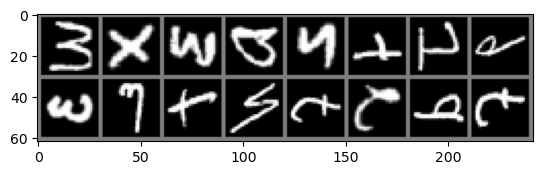

In [31]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), cmap = 'gray')
    plt.show()

dataiterator = iter(dataloaders['train'])
images, labels = next(dataiterator)

imshow(utils.make_grid(images[:16]))

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        
        model.train(mode=was_training)

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

Further Learning
================

If you would like to learn more about the applications of transfer
learning, checkout our [Quantized Transfer Learning for Computer Vision
Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).
